In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.models as models
from torch.utils.data import DataLoader

import random
import os
import copy

import torch

import sys
sys.path.append("../../")

from src.model.TransferModel import get_style_model_and_losses
from src.dataset.dataset import ImgDataset
from src.utils.other import *
from src.utils.plotting import *

In [10]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, 
                       content_layers=['conv_4'],
                       style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
                       do_print=True, device="cpu", save_interval=10, fpath=None):
    """Run the style transfer."""
    if do_print:
        print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, device,
        content_layers, style_layers)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img])
    
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    
    if do_print:
        print('Optimizing..')
    run = [0]
    count = 0
    images = []
    fig = plt.figure(figsize=(3, 3))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    image = input_img.clone().clamp_(0, 1).cpu()
    image = image.squeeze()
    image = unloader(image)
    plt.imshow(image)
    plt.close()
    data = canvas2rgb_array(fig.canvas)
    images.append(data)

    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                if do_print:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

            return style_score + content_score

        optimizer.step(closure)
        count += 10
        
        if count % save_interval == 0:
            #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            #fig = plt.figure(figsize=(5, 5))
            fig = plt.figure(figsize=(3, 3))
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            image = input_img.clone().clamp_(0, 1).cpu()
            image = image.squeeze()
            image = unloader(image)
            plt.imshow(image)
            plt.close()
            data = canvas2rgb_array(fig.canvas)
            images.append(data)
    imageio.mimsave(fpath + ".gif", images, duration=0.2)
    return input_img.clone().clamp_(0, 1).cpu()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu

cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

## lucian high noon and second to last style one

In [12]:
outfolder = "../../results/inits/"
os.system("mkdir -p " + str(outfolder))

0

In [13]:
style_dataset = ImgDataset("../../data/traditional_style_images/", imsize, device)
style_loader = DataLoader(style_dataset, batch_size=1, shuffle=False)

In [14]:
lucian_content = style_dataset.load_image("../../data/lucian-high-noon-300x545.jpg", device)
for i, style_img in enumerate(style_loader):
    if i == 6:
        break
lucian_style = style_img.squeeze(0)

yuumi_content = style_dataset.load_image("../../data/YuumiLoadScreen_19.PIE_C_11_5-300x545.jpg", device)
for i, style_img in enumerate(style_loader):
    pass
yuumi_style = style_img.squeeze(0)

riven_content = style_dataset.load_image("../../data/Riven_41-300x545.jpg", device)
for i, style_img in enumerate(style_loader):
    if i == 5:
        break
riven_style = style_img.squeeze(0)

In [15]:
style_weight = 1000000
content_weight = 1

In [16]:
# input
input_img = yuumi_content.clone()
# run style transfer
output_1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            lucian_content, lucian_style, input_img.clone(), num_steps=5000,
                            style_weight=style_weight, content_weight=content_weight,
                            do_print=True, device=device, save_interval=25,
                            fpath=outfolder + "lucian_lucian_yuumi")

fig, axes = plt.subplots(1, 4, figsize=(25, 5))
for i in range(4):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
imshow(lucian_content, axes[0], "Content Image")
imshow(lucian_style, axes[1], "Style Image")
imshow(yuumi_content, axes[2], "Input Image")
imshow(output_1, axes[3], "Output")
plt.savefig(outfolder + "lucian_lucian_yuumi")
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1157.619385 Content Loss: 80.838715

run [100]:
Style Loss : 187.582626 Content Loss: 79.719772

run [150]:
Style Loss : 88.711014 Content Loss: 79.375046

run [200]:
Style Loss : 51.571320 Content Loss: 78.461433

run [250]:
Style Loss : 33.557453 Content Loss: 77.596565

run [300]:
Style Loss : 24.211599 Content Loss: 76.401321

run [350]:
Style Loss : 18.914114 Content Loss: 75.206177

run [400]:
Style Loss : 15.312558 Content Loss: 74.066483

run [450]:
Style Loss : 12.886931 Content Loss: 72.810730

run [500]:
Style Loss : 11.524438 Content Loss: 71.680817

run [550]:
Style Loss : 10.743757 Content Loss: 70.660110

run [600]:
Style Loss : 9.450832 Content Loss: 69.766891

run [650]:
Style Loss : 8.743700 Content Loss: 68.846527

run [700]:
Style Loss : 8.188105 Content Loss: 67.978149

run [750]:
Style Loss : 7.726811 Content Loss: 67.162674

run [800]:
Style Loss : 7.442242 Content Loss: 66.381729

run [850]:

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 765.825195 Content Loss: 63.990463

run [100]:
Style Loss : 272.573669 Content Loss: 63.642235

run [150]:
Style Loss : 131.536240 Content Loss: 62.916775

run [200]:
Style Loss : 78.049248 Content Loss: 62.089054

run [250]:
Style Loss : 52.870281 Content Loss: 60.628693

run [300]:
Style Loss : 36.548073 Content Loss: 59.279552

run [350]:
Style Loss : 27.742121 Content Loss: 57.664795

run [400]:
Style Loss : 21.645535 Content Loss: 56.036236

run [450]:
Style Loss : 17.957151 Content Loss: 54.477379

run [500]:
Style Loss : 14.686455 Content Loss: 52.779057

run [550]:
Style Loss : 11.904161 Content Loss: 51.410736

run [600]:
Style Loss : 10.501842 Content Loss: 50.044479

run [650]:
Style Loss : 9.355072 Content Loss: 48.700500

run [700]:
Style Loss : 8.720254 Content Loss: 47.429462

run [750]:
Style Loss : 7.766383 Content Loss: 46.304787

run [800]:
Style Loss : 7.418041 Content Loss: 45.164803

run [850]

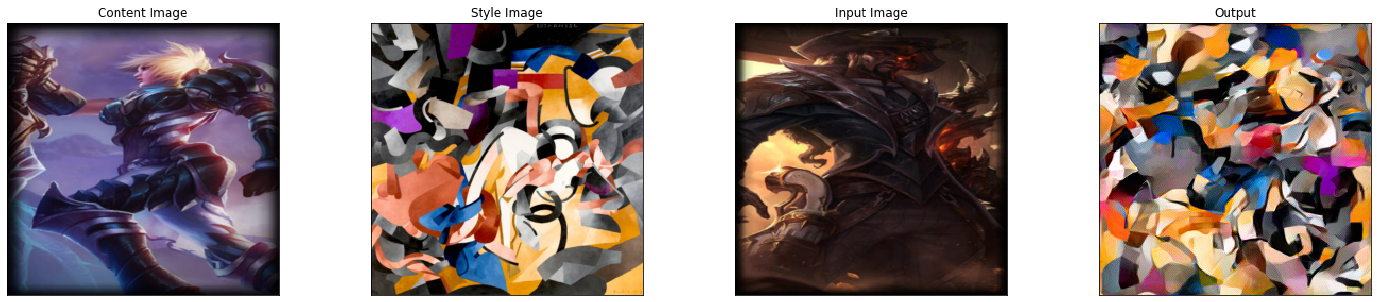

In [22]:
# input
input_img = lucian_content.clone()
# run style transfer
output_1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            riven_content, riven_style, input_img.clone(), num_steps=5000,
                            style_weight=style_weight, content_weight=content_weight,
                            do_print=True, device=device, save_interval=25,
                            fpath=outfolder + "riven_riven_lucian")

fig, axes = plt.subplots(1, 4, figsize=(25, 5))
for i in range(4):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
imshow(riven_content, axes[0], "Content Image")
imshow(riven_style, axes[1], "Style Image")
imshow(lucian_content, axes[2], "Input Image")
imshow(output_1, axes[3], "Output")
plt.savefig(outfolder + "riven_riven_lucian")
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 101.791595 Content Loss: 47.994556

run [100]:
Style Loss : 40.252567 Content Loss: 44.456673

run [150]:
Style Loss : 26.164183 Content Loss: 40.568802

run [200]:
Style Loss : 19.644691 Content Loss: 37.160744

run [250]:
Style Loss : 14.821389 Content Loss: 34.336891

run [300]:
Style Loss : 11.083743 Content Loss: 32.064522

run [350]:
Style Loss : 8.102545 Content Loss: 30.110043

run [400]:
Style Loss : 5.970390 Content Loss: 28.355648

run [450]:
Style Loss : 4.640995 Content Loss: 26.922720

run [500]:
Style Loss : 3.725189 Content Loss: 25.720932

run [550]:
Style Loss : 3.224090 Content Loss: 24.674698

run [600]:
Style Loss : 2.870871 Content Loss: 23.739563

run [650]:
Style Loss : 2.655585 Content Loss: 22.938892

run [700]:
Style Loss : 2.509998 Content Loss: 22.151451

run [750]:
Style Loss : 2.412291 Content Loss: 21.489050

run [800]:
Style Loss : 2.343761 Content Loss: 20.899548

run [850]:
Style 

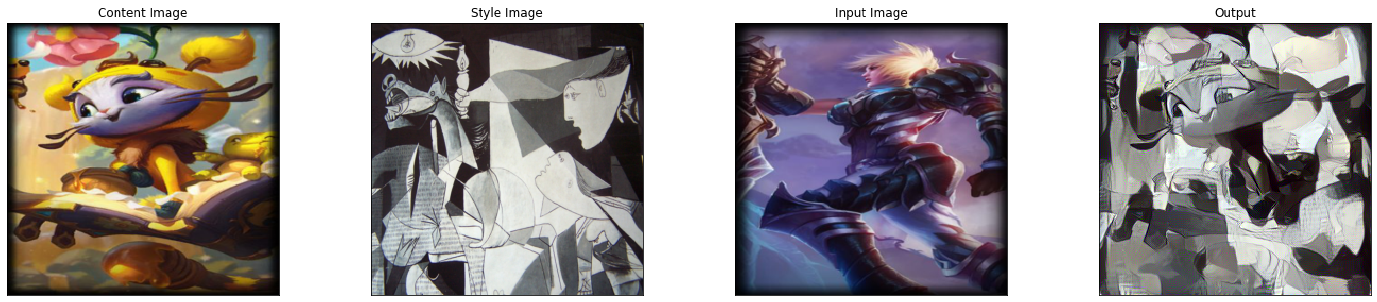

In [23]:
# input
input_img = riven_content.clone()
# run style transfer
output_1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            yuumi_content, yuumi_style, input_img.clone(), num_steps=5000,
                            style_weight=style_weight, content_weight=content_weight,
                            do_print=True, device=device, save_interval=25,
                            fpath=outfolder + "yuumi_yuumi_riven")

fig, axes = plt.subplots(1, 4, figsize=(25, 5))
for i in range(4):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
imshow(yuumi_content, axes[0], "Content Image")
imshow(yuumi_style, axes[1], "Style Image")
imshow(riven_content, axes[2], "Input Image")
imshow(output_1, axes[3], "Output")
plt.savefig(outfolder + "yuumi_yuumi_riven")
plt.show()